# Imports

In [110]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
import os
import shutil
import folium
import shapely
import matplotlib
from ipywidgets import interact
import seaborn as sns
import math
import stats
import scipy

# Data

In [192]:
# importing all files including the shapes
geo = gpd.read_file('wdl_data/m_risk_prfile.geojson')
df = pd.DataFrame(geo).drop(columns=['geometry', 'Link_ID'])

In [174]:
# df.describe()

,linkid,Daily_Aver,Average_Ve,Median_of_,First_Quar,Third_Quar,Func_Class,Speed_Cat
count,3.467800e+04,34678.000000,34678.000000,34678.000000,34678.000000,34678.000000,34678.000000,34678.000000
mean,8.958206e+08,3340.417942,56.816834,56.463409,43.822041,68.091844,2.684613,4.904781
std,2.355910e+08,2725.873982,51.983670,26.240876,24.442204,30.985191,0.538658,1.520568
min,8.021682e+07,14.435864,-401.703724,1.000000,-392.500000,1.000000,1.000000,2.000000
25%,7.364832e+08,1903.398108,38.315321,38.250000,26.000000,48.000000,2.000000,4.000000
50%,9.067377e+08,2644.529317,49.966126,50.000000,38.875000,60.333333,3.000000,6.000000
75%,1.154997e+09,3897.886608,69.511585,71.000000,56.000000,85.000000,3.000000,6.000000
max,1.223731e+09,49309.806935,6357.022296,1326.250000,143.000000,2605.000000,3.000000,7.000000


In [7]:
geo.nunique(), df.shape
## Linkid is a unique identifier for the dataset

(Link_ID       34678
 linkid        34678
 Daily_Aver    34077
 Average_Ve    32726
 Median_of_     3621
 First_Quar     2807
 Third_Quar     2808
 Func_Class        3
 Speed_Cat         6
 geometry      34673
 dtype: int64,
 (34678, 8))

**Note**<br>
There are **34678** unique road segments in the data set.

In [ ]:
# calculating length of lines with epsg:5018 for Lisbon (~2m accuracy)
## further investiagation: GCS_WGS_1984 -- is written in the files
tot_l = geo.geometry.to_crs(epsg=5018).length.sum()
print(f'the road segments provided in data have a total length of \n{round(tot_l, 2)} m \n{round(tot_l/1000, 2)} km')

In [ ]:
geo

In [ ]:
## Filtering only lisbon data at 38.72526068747401, -9.142352617846093
circle_lisbon = shapely.geometry.Point(-9.142352617846093, 38.72526068747401).buffer(1)
geo_lis = geo[geo.geometry.within(circle)]

In [ ]:
geo_lis.linkid
# left 17.688 shapes in the df

In [ ]:
## looking for speed cat specs
df.Speed_Cat.describe()

In [ ]:
# manually accessing the geodata (without gpd)
with open('wdl_data/m_risk_prfile.geojson') as f:
    geol = json.load(f)
    


In [8]:
geo.columns

Index(['Link_ID', 'linkid', 'Daily_Aver', 'Average_Ve', 'Median_of_',
       'First_Quar', 'Third_Quar', 'Func_Class', 'Speed_Cat', 'geometry'],
      dtype='object')

In [ ]:
# charts = ["Statistics", "Results 2018"]

# ## TESTPLOT
# @interact(tiles=charts)
def create_map(circle_lisbon=circle_lisbon, geol=geol):
    m = folium.Map([38.74288, -9.16624])

    folium.Choropleth(geo_data=circle_lisbon, 
                      name="Circle", 
                      fill_color="yellow", 
                      fill_opacity=.3, 
                      show=False).add_to(m)

    # roads by speed cat
    roads = folium.map.FeatureGroup(name='Roads')
    cmap = matplotlib.cm.get_cmap('coolwarm')
    norm = matplotlib.colors.Normalize(vmin=2, vmax=6)

    for feat in geol['features']:
        coords = feat['geometry']['coordinates'][0]
        # flipping lat, lng
        _co = [[co[1], co[0]] for co in coords]
        speed = feat['properties']['Speed_Cat']
        rgba = cmap(norm(speed))
        hexa = matplotlib.colors.to_hex(rgba)
        folium.PolyLine(_co, color=hexa, opacity=1, weight=4).add_to(roads)

    roads.add_to(m)

    folium.LayerControl().add_to(m)

    return m

# Acquiring more information

In [193]:
# change column names
df_ren = df.rename(columns={
                    'Daily_Aver':'Daily_Average_Traffic_Intensity',
                    'Average_Ve':'Average_Velocity_of_Vehicle_Traffic',
                    'Median_of_':'Median_of_velocity_of_Vehicle_Traffic',
                    'First_Quar': 'FirstQuartil_of_velocity_of_Vehicle_Traffic',
                    'Third_Quar': 'ThirdQuartil_of_velocity_of_Vehicle_Traffic'
                })

In [194]:
df_ren.dtypes

linkid                                           int64
Daily_Average_Traffic_Intensity                float64
Average_Velocity_of_Vehicle_Traffic            float64
Median_of_velocity_of_Vehicle_Traffic          float64
FirstQuartil_of_velocity_of_Vehicle_Traffic    float64
ThirdQuartil_of_velocity_of_Vehicle_Traffic    float64
Func_Class                                       int64
Speed_Cat                                        int64
dtype: object

In [195]:
# remove outliers
def rm_out(df):
    for i in df.columns.drop(['linkid', 'Daily_Average_Traffic_Intensity']):
        lb = 0
        ub = 180
#         print(lb, ub)
        df[i] = df[i].mask(df[i] < lb) 
        df[i] = df[i].mask(df[i] > ub) 
    return df

df_cl = rm_out(df_ren)
df_cl

,linkid,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Func_Class,Speed_Cat
0,80216819,6224.778569,45.208716,44.464286,28.000000,59.00,2,6
1,80216858,2236.054168,79.563308,82.750000,71.750000,93.25,2,4
2,80216859,2138.725039,65.955069,67.333333,61.000000,75.00,3,6
3,80216860,2201.335041,47.533911,44.000000,26.900000,74.00,3,6
4,80216867,2102.610278,51.375291,53.250000,45.333333,59.00,3,6
...,...,...,...,...,...,...,...,...
34673,1223266734,2301.997364,44.392857,43.500000,37.000000,50.00,3,4
34674,1223277122,1655.507135,106.848684,109.500000,88.000000,124.00,2,3
34675,1223277123,1665.608140,108.863821,114.250000,90.000000,124.50,2,3
34676,1223277124,2580.645483,104.774517,108.375000,94.200000,122.00,2,3


In [196]:
# df_cl = df_cl.dropna()

In [197]:
df_cl.describe()

,linkid,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Func_Class,Speed_Cat
count,3.467800e+04,34678.000000,34633.000000,34675.000000,34677.000000,34674.000000,34678.000000,34678.000000
mean,8.958206e+08,3340.417942,56.112805,56.402803,43.834624,67.959767,2.684613,4.904781
std,2.355910e+08,2725.873982,24.346245,25.054113,24.329987,26.706718,0.538658,1.520568
min,8.021682e+07,14.435864,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000
25%,7.364832e+08,1903.398108,38.317003,38.250000,26.000000,48.000000,2.000000,4.000000
50%,9.067377e+08,2644.529317,49.961538,50.000000,38.875000,60.333333,3.000000,6.000000
75%,1.154997e+09,3897.886608,69.447459,71.000000,56.000000,85.000000,3.000000,6.000000
max,1.223731e+09,49309.806935,179.691892,143.250000,143.000000,164.000000,3.000000,7.000000


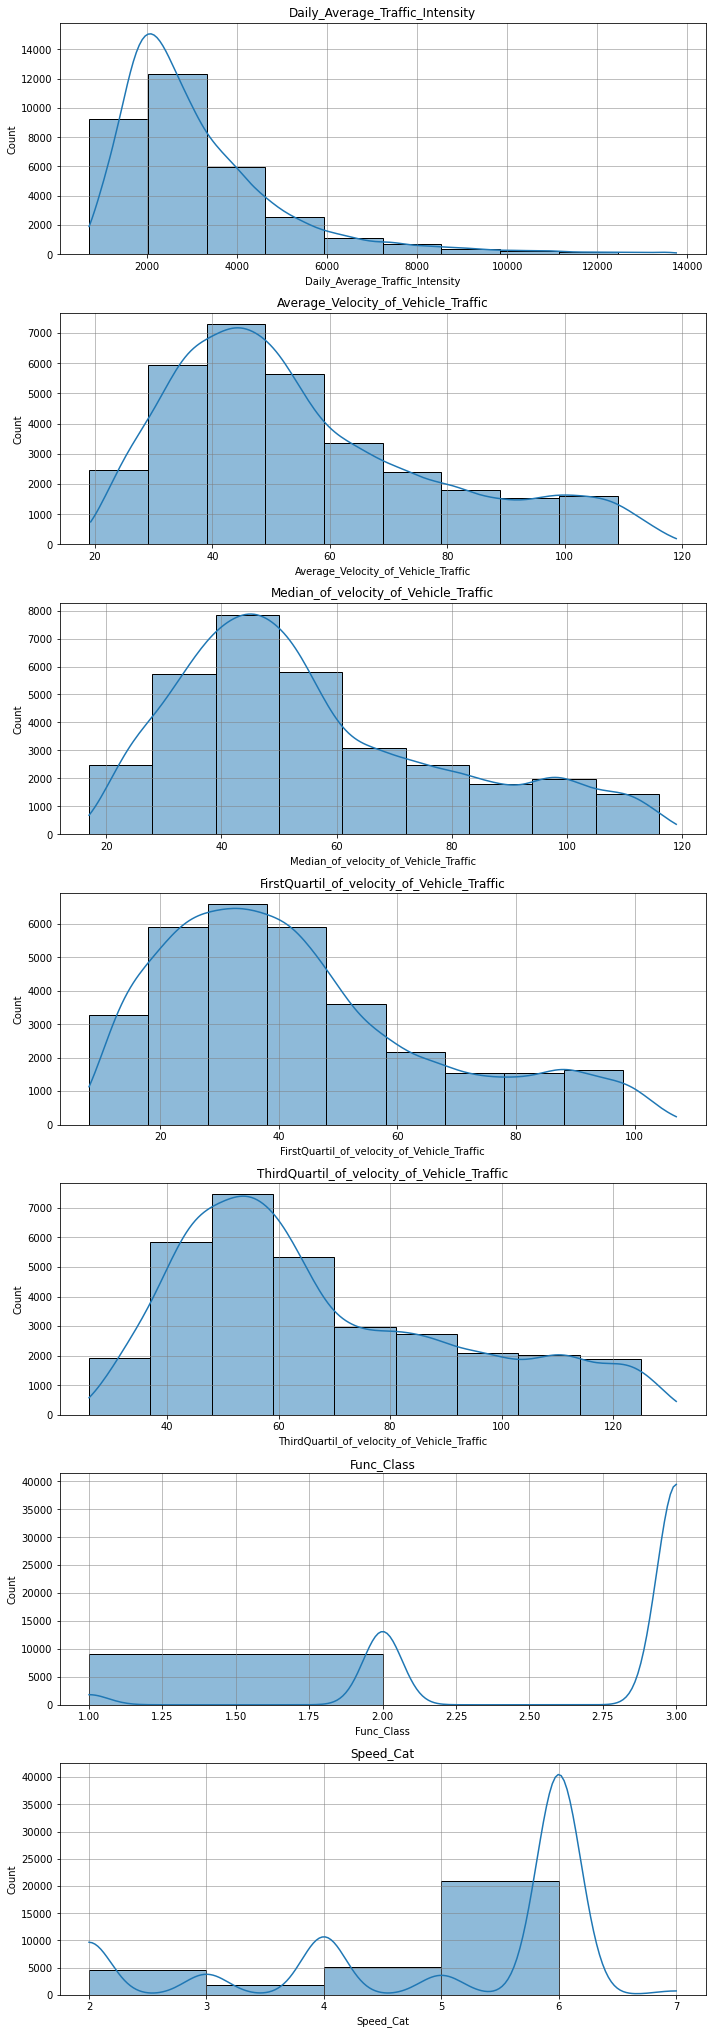

In [170]:
plt.figure(figsize=(10,40))

for c, i in enumerate(df_cl.columns.drop('linkid')):
    grid = (int(df_cl[i].min()), int(df_cl[i].max()))
    rng = (int(df_cl[i].max())-int(df_cl[i].min()))
    plt.subplot(10,1,c+1, ).grid(True, linewidth=0.5, color='grey', linestyle='-')
    sns.histplot(df_cl[i], bins=range(grid[0], grid[1], math.ceil(rng/10)), kde=True)
    plt.title(i)
    plt.tight_layout()

,linkid,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Func_Class,Speed_Cat
linkid,1.000000,0.034440,0.049190,0.054230,0.041986,0.055147,0.014518,-0.066174
Daily_Average_Traffic_Intensity,0.034440,1.000000,0.068204,0.082494,0.038746,0.092137,-0.184087,-0.164776
Average_Velocity_of_Vehicle_Traffic,0.049190,0.068204,1.000000,0.982949,0.957711,0.969862,-0.626376,-0.772173
Median_of_velocity_of_Vehicle_Traffic,0.054230,0.082494,0.982949,1.000000,0.953696,0.964950,-0.626097,-0.781783
FirstQuartil_of_velocity_of_Vehicle_Traffic,0.041986,0.038746,0.957711,0.953696,1.000000,0.891248,-0.576033,-0.731255
ThirdQuartil_of_velocity_of_Vehicle_Traffic,0.055147,0.092137,0.969862,0.964950,0.891248,1.000000,-0.637341,-0.775705
Func_Class,0.014518,-0.184087,-0.626376,-0.626097,-0.576033,-0.637341,1.000000,0.630617
Speed_Cat,-0.066174,-0.164776,-0.772173,-0.781783,-0.731255,-0.775705,0.630617,1.000000


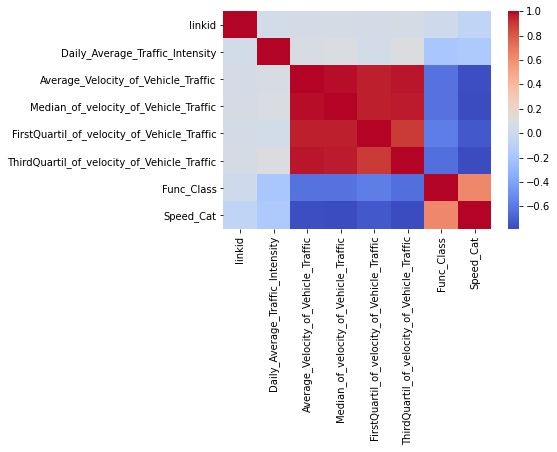

In [171]:
corr = df_cl.corr()
sns.heatmap(corr, cmap='coolwarm')
corr